# Hito 2

## Descargamos librerias, descargamos las imagenes y guardamos su informacion en archivo npy

In [1]:
import cv2
import numpy as np
import pandas
import imageio.v3 as io

from tqdm import tqdm
from typing import Optional, Union

In [2]:
def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
  """ Download a list of images from url adresses, converting them to a specific
  canvas size.

  Args:
    paths: Paths or url adresses from which to load images.
    canvas: Desired image width and height.
    nb_channels: Channels in images (1 for B/W, 3 for RGB).
    max_imgs: Upper threshold in the number of images to download.

  Return:
    a tuple of:
      - image values
      - indices within the paths that were successfull.

  """
  n_images = len(paths) if not max_imgs else max_imgs
  images = np.zeros((n_images, canvas[0], canvas[1], nb_channels),
                       dtype=np.uint8)
  downloaded_idxs = []

  for i_img, url in enumerate(tqdm(paths, total=n_images)):
    if i_img >= n_images:
      break
    try:
        img = io.imread(url)
        img = cv2.resize(img, (canvas[0], canvas[1]))
        downloaded_idxs.append(i_img)
        images[i_img] = img
    except (IOError, ValueError) as e:  # Unavailable url / conversion error
        pass
  return images[downloaded_idxs], downloaded_idxs

In [4]:
# descargamos los datos
data = pandas.read_csv("dataset.csv", sep = ';')

# eliminamos los valores nulos de price
data = data.dropna(subset=['price'])

# eliminamos posibles filas duplicadas
data = data.drop_duplicates()

# descargamos las imagenes para obtener saber que datos vamos a usar
images , idx = download_images(data['picture_url'])



100%|██████████| 3600/3600 [14:36<00:00,  4.11it/s]


In [5]:
# normalizamos las imagenes y las guardamos
images = images.astype("float32") / 255.
print(images.shape)
np.save('images.npy', images)

(3130, 224, 224, 3)


In [6]:
# Filtrar los datos y crear una copia
data_filtered = data.iloc[idx].copy()

# Eliminamos el símbolo del dólar y lo convertimos a numérico
data_filtered['price'] = data_filtered['price'].str.lstrip('$')
data_filtered['price'] = data_filtered['price'].str.replace(',', '', regex=True).astype(float)

# Guardamos los precios
np.save('prices.npy', data_filtered['price'])


In [7]:
# verificamos que se tenga la misma longuitud en ambos
assert len(images) == len(data_filtered['price'])

## Cargamos los archivos

In [26]:
import numpy as np

# cargamos las imagenes y los precios
images = np.load('images.npy')
prices = np.load('prices.npy')

print(f"Imágenes cargadas: {images.shape}")
print(f"Precios cargados: {prices.shape}")


Imágenes cargadas: (3130, 224, 224, 3)
Precios cargados: (3130,)


## Dividimos los datos

In [27]:
from sklearn.model_selection import train_test_split

# dividimos primero en train y test
X_train, X_test, y_train, y_test = train_test_split(images, prices, test_size=0.2, random_state=42)

# dividimos el conjunto de entrenamiento en train y validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


print(f"Entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Validación: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")


Entrenamiento: (1878, 224, 224, 3), (1878,)
Validación: (626, 224, 224, 3), (626,)
Test: (626, 224, 224, 3), (626,)


## Creamos el modelo y realizamos transfer-learning

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models,Model

# creamos el modelo preentrenado con VGG16 con les pesos de imagenet, indicamos que no incluya las capas densas
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# congelamos todas las capas para que no actualice los pesos
base_model.trainable = False

# contruimos la capas densas (top model)
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)

# convertimos a vector
x = layers.Flatten()(x)

# añadimos capas densas
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
# entrenamos el modelo guardando el historico
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=128
)


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 989ms/step - loss: 83554.1016 - mae: 136.7466 - val_loss: 182170.8906 - val_mae: 161.0565
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 784ms/step - loss: 88903.2344 - mae: 137.7005 - val_loss: 179827.0156 - val_mae: 122.4130
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 747ms/step - loss: 91793.1094 - mae: 107.1254 - val_loss: 178047.6875 - val_mae: 133.3839
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 916ms/step - loss: 100847.2891 - mae: 120.5431 - val_loss: 177472.3281 - val_mae: 127.4824
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 937ms/step - loss: 89201.8516 - mae: 120.9143 - val_loss: 176859.5781 - val_mae: 128.0014
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 780ms/step - loss: 65021.9141 - mae: 110.8874 - val_loss: 176306.4688 - val_mae: 126.5262
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 916ms/step - loss: 123549.4531 - mae: 116.4528 - val_loss: 176124.0781 - val_mae: 121.7744
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 765ms/step - loss: 72057.2422 - 

In [19]:
# comprobamos con los datos de prueba
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Loss en el conjunto de prueba: {test_loss}")
print(f"MAE en el conjunto de prueba: {test_mae}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - loss: 21827.5469 - mae: 96.6021
Loss en el conjunto de prueba: 22571.259765625
MAE en el conjunto de prueba: 96.48690032958984


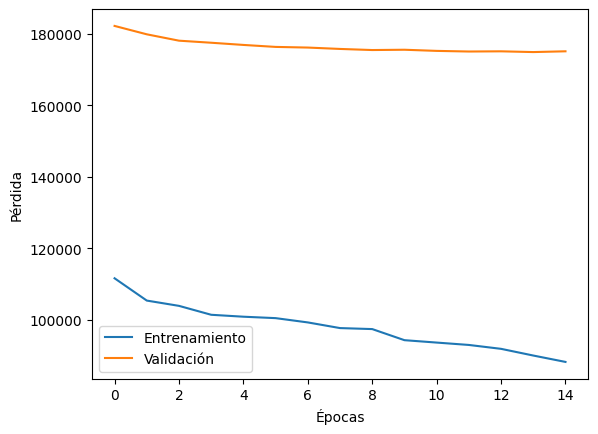

In [21]:
import matplotlib.pyplot as plt

# mostramos la grafica
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Observamos una tendencia a la baja lo que nos puede llevar a la conclusion que aumentando las epocas el error puede bajar


## Fine tuning

In [28]:
from tensorflow.keras.applications import VGG16
# creamos el modelo preentrenado con VGG16 con les pesos de imagenet, indicamos que no incluya las capas densas
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models,Model
from tensorflow.keras.optimizers import Adam

# nos quedamos con el ultimo bloque convolucional
for layer in base_model.layers:
  layer.trainable = False
  if layer.name == "block5_conv3":
    layer.trainable = True


# contruimos la capas densas (top model)
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)

# convertimos a vector
x = layers.Flatten()(x)

# añadimos capas densas
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.9)(x)
outputs = layers.Dense(1)(x)

model = Model(inputs, outputs)

optimizer = Adam(learning_rate=0.1)
# Compilar el modelo
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 5,571,329 (21.25 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [39]:
# entrenamos el modelo guardando el historico
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - loss: 8040991744.0000 - mae: 25102.2637 - val_loss: 215278.8281 - val_mae: 193.4588
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - loss: 188840.0469 - mae: 187.8874 - val_loss: 208141.2812 - val_mae: 178.1948
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 461ms/step - loss: 173198.6562 - mae: 180.0599 - val_loss: 202572.1094 - val_mae: 157.6248
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 390ms/step - loss: 147611.9688 - mae: 158.0816 - val_loss: 197779.4219 - val_mae: 142.9868
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 377ms/step - loss: 191089.8594 - mae: 165.5729 - val_loss: 192548.5469 - val_mae: 129.6291
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - loss: 267608.6250 - mae: 164.8427 - val_loss: 188851.1719 - val_mae: 122.4812
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 388ms/step - loss: 178946.4219 - mae: 154.4563 - val_loss: 188804.5000 - val_mae: 122.4349
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 374ms/step - loss: 21592

Observamos valores mejores en validacion que en test

## Hacemos una busqueda de hiperparametros

In [ ]:
import tensorflow as tf
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np



def objective(params):
    # creamos el modelo base preentrenado
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    # creamos el modelo personalizado
    inputs = layers.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(params['dropout'])(x)
    outputs = layers.Dense(1)(x)

    model = Model(inputs, outputs)

    # compilamos
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # entrenamos
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=int(params['batch_size']),
        verbose=0
    )

    # obtenemos la métrica de validación (MAE) como criterio de optimización
    val_mae = history.history['val_mae'][-1]
    return {'loss': val_mae, 'status': STATUS_OK}

# Espacio
space = {
    'dropout': hp.uniform('dropout', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'batch_size': hp.quniform('batch_size', 16, 64, 128)
}

# buscamos
trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials
)

print("Mejores hiperparámetros:", best_params)



  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]